In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import wandb

from acai.autoencoders.base import AutoencoderBase
from acai.backbones import build_simple_encoder, build_simple_decoder
from acai.data.line_dataloader import LineDataLoader
# from acai.image_utils import collage_images, torch2numpy_image, draw_images
from acai.wandb_logger import WandbLogger
from acai.utils import init_weights_kaiming_normal, fix_seeds
# from acai.monitoring.base import MonitoringCallbackBase
# from acai.monitoring.factory import MonitoringFactory, MonitoringType
from acai.training.trainer import Trainer

In [3]:
BATCHSIZE = 64

# Quick look into data

100%|██████████| 10/10 [00:00<00:00, 25970.92it/s]


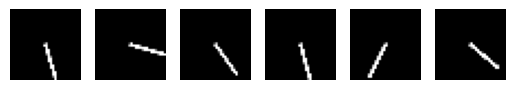

In [6]:
from acai.data.line_image_generation import make_line_image
from acai.image_utils import draw_images
fix_seeds(0)
angles = np.random.uniform(-3, 3, size=10)
images = np.stack([make_line_image(angle) for angle in tqdm.tqdm(angles)])
images = images / 255
images = images.astype(np.float32)
draw_images(images[:6])

## Train AE

In [7]:
class AutoencoderTrainer(Trainer):
    def _configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr=3e-4)

    def _train_step(self):
        self.autoencoder.train()
        batch = self.dataloader.get_train_batch()
        first_image = torch2numpy_image(batch[0])
        out = self.autoencoder(batch)
        loss = out['loss']
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.logger.log({"ae/train/loss": loss.detach().item()})
        self.logger.log_images(
            "ae/train/images/first_image_in_batch_reconstruction", 
            collage_images([
                first_image, 
                torch2numpy_image(out['reconstructed_images'][0]),
            ])
        )

    def _eval_step(self, batch):
        self.autoencoder.eval()
        out = self.autoencoder(batch)
        loss = out['loss']
        self.logger.log({"ae/test/loss": loss.detach().item()})

In [10]:
from acai.autoencoders.autoencoder import AutoencoderDefault
fix_seeds(42)

dataloader = LineDataLoader
logger = WandbLogger(run='ae_refactored_trainer', project='acai_karpathy', log_images_every=100)
encoder = build_simple_encoder(width_coef=1)
decoder = build_simple_decoder(width_coef=1)
autoencoder = AutoencoderDefault(encoder, decoder)
autoencoder.apply(init_weights_kaiming_normal)

trainer = AutoencoderTrainer(autoencoder, dataloader, logger=logger, device=torch.device("cuda"))
trainer.train(n_steps=260000)

AttributeError: 'int' object has no attribute 'batch_size'

# Train ACAI

In [ ]:
from acai.autoencoders.acai import ACAI
from acai.monitoring.interpolation import InterpolationMonitoring


class ACAITrainer(Trainer):
    def _configure_optimizers(self):
        self.optimizer_ae = torch.optim.Adam(
            [
                *self.autoencoder.encoder.parameters(), 
                *self.autoencoder.decoder.parameters(),
            ], 
            lr=3e-4
        )
        self.optimizer_critic = torch.optim.Adam(self.autoencoder.critic.parameters(), lr=3e-4)
    
    def _train_step(self):
        self._train_ae()
        self._train_critic()
    
    def _train_ae(self):
        batch = self.dataloader.get_train_batch()
        batch4interpolation = self.dataloader.get_train_batch()
        first_image = torch2numpy_image(batch[0])
        out = self.autoencoder(batch, batch4interpolation)
        self.optimizer_ae.zero_grad()
        out['loss'].backward()
        self.optimizer_ae.step()

        self.logger.log({"ae/train/loss": out['loss'].detach().item()})
        self.logger.log({"ae/train/reconstruction_loss": out['reconstruction_loss'].detach().item()})
        self.logger.log({"ae/train/interpolation_loss": out['interpolation_loss'].detach().item()})
        self.logger.log_images(
            "ae/train/images/first_image_in_batch_reconstruction", 
            collage_images([first_image, torch2numpy_image(out['reconstructed_images'][0])])
        )
        self.logger.log_images(
            "ae/train/images/decoded_interpolation",
            torch2numpy_image(out["reconstructed_interpolated_images"][0]),
        )
        
    def _train_critic(self):
        batch = self.dataloader.get_train_batch()
        batch4interpolation = self.dataloader.get_train_batch()
        first_image = torch2numpy_image(batch[0])
        out = self.autoencoder.forward_critic(batch, batch4interpolation)
        self.optimizer_critic.zero_grad()
        out['loss'].backward()
        self.optimizer_critic.step()

        self.logger.log({"critic/train/loss": out['loss'].detach().item()})
        self.logger.log({"critic/train/alpha_recovery_loss": out['alpha_recovery_loss'].detach().item()})
        self.logger.log({"critic/train/regularization_loss": out['regularization_loss'].detach().item()})
        self.logger.log_images(
            "critic/train/images/first_image_in_batch", 
            collage_images([first_image, torch2numpy_image(out['reconstructed_images'][0])])
        )
        self.logger.log_images(
            "critic/train/images/decoded_interpolation",
            torch2numpy_image(out["reconstructed_interpolated_images"][0]),
        )
        self.logger.log_images(
            "critic/train/images/blended_input_image",
            torch2numpy_image(out["blended_non_interpolated_images"][0]),
        )

    def _eval_step(self, batch):
        self.autoencoder.eval()
        batch4interpolation = self.dataloader.get_train_batch()
        out = self.autoencoder(batch, batch4interpolation)
        self.logger.log({"ae/test/loss": out['loss'].detach().item()})

In [ ]:
fix_seeds(42)

logger = WandbLogger(run='acai__refactored_trainer', project='acai_karpathy', log_images_every=100)
encoder = build_simple_encoder(width_coef=1)
decoder = build_simple_decoder(width_coef=1)
critic = build_simple_encoder(width_coef=1)
autoencoder = ACAI(encoder, decoder, critic)
autoencoder.apply(init_weights_kaiming_normal)

trainer = ACAITrainer(autoencoder, dataloader, logger=logger, device=torch.device("cuda"))
trainer.train(n_steps=260000)

ae/test/loss,█▆▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ae/train/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ae/test/loss,0.00194
ae/train/loss,0.00219
